In [ ]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same value


print(X.shape), print(y.shape), print(X.dtype), print(type(X))


(1000, 2)
(1000,)
float64
<class 'numpy.ndarray'>


(None, None, None, None)

In [ ]:
# convert to tensor ----> since Sklearn leverages Numpy, we should first convert data imported from it to tensors

X=torch.from_numpy(X)
X=X.type(torch.float32)

y=torch.from_numpy(y).unsqueeze(dim=1)
y=y.type(torch.float32)
#checking...
print(X.shape), print(y.shape), print(X.dtype), print(type(X))
print(y.dtype), print(type(y))

torch.Size([1000, 2])
torch.Size([1000, 1])
torch.float32
<class 'torch.Tensor'>
torch.float32
<class 'torch.Tensor'>


(None, None)

In [ ]:
# seeing data as a table (data frame):
import pandas as pd
circles=pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y.squeeze()}) #we get error if we do not use squeeze
circles.head()

,X1,X2,label
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


In [ ]:
circles.label.value_counts()

label
1.0    500
0.0    500
Name: count, dtype: int64

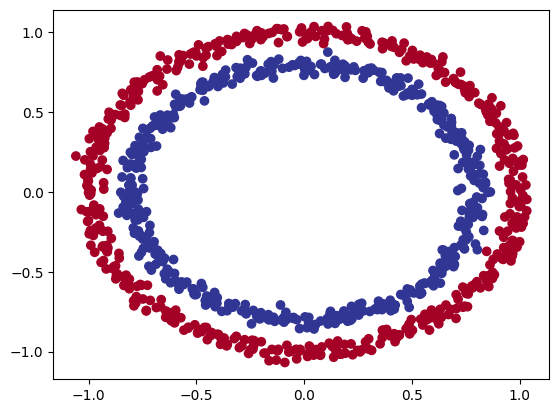

In [ ]:
# Plot
plotty=plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

# Adding legend
#legend_elements = plotty.legend_elements()[0]
#plt.legend(plotty.legend_elements()[0], ['y=1', 'y=0'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


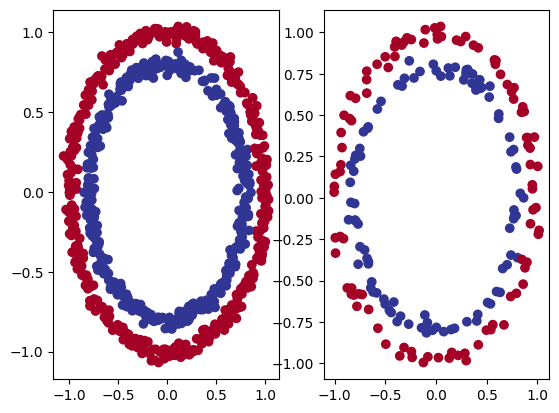

In [ ]:
# plot spllited data
plt.subplot(1,2,1).scatter(X_train[:,0],X_train[:,1],c=y_train,cmap=plt.cm.RdYlBu)#index in subplot statrts from 1
plt.subplot(1,2,2).scatter(X_test[:,0],X_test[:,1],c=y_test,cmap=plt.cm.RdYlBu)

In [ ]:
def acc_fn(output,target):
 correct = torch.eq(target, output).sum().item() # torch.eq() calculates where two tensors are equal
 acc = (correct / len(output)) * 100
 return acc

In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [ ]:
class model_BC(nn.Module):

 def __init__(self):
  super().__init__()
  self.layer_1=nn.Linear(in_features=2,out_features=10)
  self.layer_2=nn.Linear(in_features=10,out_features=10)
  self.layer_3=nn.Linear(in_features=10,out_features=1)
  self.relu=nn.ReLU()


 def forward(self,x):
  return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_0bc=model_BC()

In [ ]:
Loss_fn=torch.nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_0bc.parameters(),lr=0.1)

In [ ]:
torch.manual_seed(42)
epochs=1000

for epoch in range(epochs):
 model_0bc.train()

 #3.1- forward pass
 ytrain_pred=model_0bc(X_train)

 #3.2- calculate the loss
 Loss=Loss_fn(ytrain_pred,y_train) #first argument for built_in loss functions is output and second one is target

 # 3.3- backpropagation and parameters update:
 optimizer.zero_grad()

 Loss.backward()

 optimizer.step()

 #Testing
 model_0bc.eval()

 with torch.inference_mode():
   ytest_pred=model_0bc(X_test)

   #calculating accuracy
   ytrainrounded=torch.round(torch.sigmoid(ytrain_pred))
   ytestrounded=torch.round(torch.sigmoid(ytest_pred))
   accuracytr=acc_fn(ytrainrounded,y_train)
   accuracytst=acc_fn(ytestrounded,y_test)
   Loss_test=Loss_fn(ytest_pred,y_test)

 #print out the results:

 if epoch %100==0:
  print(f"The train Loss is {Loss} and the test Loss is {Loss_test}| training accuracy is {accuracytr:.4f} and testing accuracy is {accuracytst:.4f}")


The train Loss is 0.6968845129013062 and the test Loss is 0.6977040767669678| training accuracy is 48.6250 and testing accuracy is 45.5000
The train Loss is 0.6916722059249878 and the test Loss is 0.69329434633255| training accuracy is 55.2500 and testing accuracy is 51.0000
The train Loss is 0.6887294054031372 and the test Loss is 0.6913856267929077| training accuracy is 55.1250 and testing accuracy is 53.0000
The train Loss is 0.6854485273361206 and the test Loss is 0.6894179582595825| training accuracy is 55.7500 and testing accuracy is 53.0000
The train Loss is 0.6809253096580505 and the test Loss is 0.6865903735160828| training accuracy is 57.7500 and testing accuracy is 54.5000
The train Loss is 0.6738414168357849 and the test Loss is 0.6816247701644897| training accuracy is 62.3750 and testing accuracy is 59.5000
The train Loss is 0.6614422798156738 and the test Loss is 0.6718910336494446| training accuracy is 70.8750 and testing accuracy is 65.0000
The train Loss is 0.638262569

Text(0.5, 1.0, 'test data')

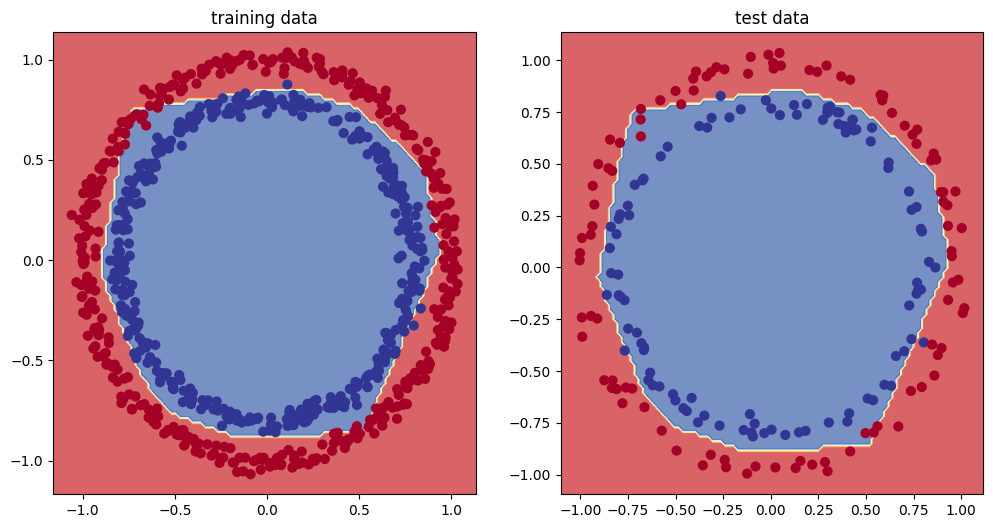

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plot_decision_boundary(model_0bc, X_train, y_train)
plt.title('training data')
plt.subplot(1,2,2)
plot_decision_boundary(model_0bc, X_test, y_test)
plt.title('test data')